In [1]:
from skykatana import SkyMaskPipe, build_radial_model #make_profile_arcsec_model_from_profiles
import healpy as hp, healsparse as hsp, pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Polygon; from mocpy import MOC, WCS
from astropy.coordinates import Angle, SkyCoord, Latitude, Longitude; import astropy.units as u
from functools import partial; import lsdb
import re; from pathlib import Path

#%matplotlib widget
#%matplotlib inline

In [2]:
# Define files and parameters ############################################
lconefile = './euclid/small.parquet'         # mock lightcone data file
profdir   = './densprof'                     # location of density profiles
gaiadir   = './gaiaEuclid/'                  # location of Gaia data
WM_order_sparse = 15 ; WM_order_cov=5        # orders for the weight mask
WM_band         = 'r'                        # band for weight mask 
WM_outdir       = './euclid/small'           # directory to save weight mask
###########################################################################

In [3]:
_PAT = re.compile(r"^dens_profile_(?P<band>[ugrizy])_(?P<m1>-?\d+(?:\.\d+)?)\-(?P<m2>-?\d+(?:\.\d+)?)\.npy$")
def load_profiles_from_npy(dirpath: str | Path):
    """
    Read radial density profiles from:
      - distance_to_center.npy  (arcsec)
      - dens_profile_[band]_[m1-m2].npy

    Returns
    -------
    profiles : dict
        profiles[band][(m1,m2)] = (r_arcsec, p_array)
    mag_bins : list[tuple[float,float]]
        Sorted unique magnitude bins found in files.
    r_arcsec : np.ndarray
        The common radius array (arcsec).
    """
    dirpath = Path(dirpath)

    r_path = dirpath / "distance_to_center.npy"
    if not r_path.exists():
        raise FileNotFoundError(f"Missing {r_path}")

    r_arcsec = np.load(r_path).astype(float)
    if r_arcsec.ndim != 1:
        raise ValueError("distance_to_center.npy must be 1D")

    profiles: dict[str, dict[tuple[float, float], tuple[np.ndarray, np.ndarray]]] = {}
    mag_bin_set: set[tuple[float, float]] = set()

    for fp in sorted(dirpath.glob("dens_profile_*_*.npy")):
        m = _PAT.match(fp.name)
        if m is None:
            # ignore unexpected files
            continue

        band = m.group("band")
        m1 = float(m.group("m1"))
        m2 = float(m.group("m2"))
        mag_bin = (m1, m2)

        p = np.load(fp).astype(float)
        if p.shape != r_arcsec.shape:
            raise ValueError(f"Shape mismatch for {fp.name}: p{p.shape} vs r{r_arcsec.shape}")

        profiles.setdefault(band, {})[mag_bin] = (r_arcsec, p)
        mag_bin_set.add(mag_bin)

    if not profiles:
        raise RuntimeError(f"No dens_profile files found in {dirpath}")

    # Sort bins by lower edge then upper edge
    mag_bins = sorted(mag_bin_set, key=lambda t: (t[0], t[1]))

    # Optional sanity check: every band has every bin
    missing = {}
    for band, d in profiles.items():
        miss = [mb for mb in mag_bins if mb not in d]
        if miss:
            missing[band] = miss
    if missing:
        # not fatal, but good to know
        print("Warning: missing bins for some bands:")
        for band, miss in missing.items():
            print(" ", band, "missing", miss)

    return profiles, mag_bins, r_arcsec

In [4]:
def plotprofiles(profiles, mag_bins, band='r', figsize=[8,5], xlim=[0,250], ylim=[0,1.3], legendfs=9):
    plt.figure(figsize=figsize)
    for mag_bin in mag_bins:
        r, p = profiles[band][mag_bin]
        plt.plot(r, p, label=f"{mag_bin[0]:.1f}–{mag_bin[1]:.1f}")
    
    plt.xlabel("radius [arcsec]")
    plt.ylabel("normalized source density")
    plt.title(f"Radial density profiles – {band}-band")
    plt.legend(title="Gaia G mag", fontsize=legendfs)
    plt.grid(alpha=0.3)
    plt.xlim(xlim) ; plt.ylim(ylim)
    plt.tight_layout()
    plt.show()

In [5]:
def inject_star_deficit_from_weightmask(
    ra_deg, dec_deg,
    wmask_hsp,                 # HealSparseMap float, w>=1 (ideally)
    rng=None,
    wcap=None,                 # optional cap on weights (e.g. 5 or 10)
    unseen_to_unity=True,      # if map is unseen at a position, set w=1
):
    """
    Inject a statistical deficit into a mock catalog by thinning with probability c=1/w,
    where w is the (Skykatana) weight mask sampled at each galaxy position.

    Returns
    -------
    keep : boolean array
        Mask selecting galaxies kept in the 'observed' (deficit-injected) catalog.
    w_gal : float array
        Weight sampled at each galaxy position (use on the kept galaxies for correction).
    c_gal : float array
        Completeness probability used for thinning (clipped to [0,1]).
    """
    if rng is None:
        rng = np.random.default_rng()

    ra_deg = np.asarray(ra_deg)
    dec_deg = np.asarray(dec_deg)

    # Sample the HealSparse map at points.
    # HealSparse supports get_values_pos(ra, dec, lonlat=True/latlon=True depending on version).
    # Try lonlat=True first; adjust if your version uses lonlat/latlon.
    w_gal = wmask_hsp.get_values_pos(ra_deg, dec_deg, lonlat=True)

    # Handle "unseen" / invalid values if needed
    # HealSparse unseen for float maps is often np.nan, or a special sentinel.
    # We'll treat non-finite as unseen.
    if unseen_to_unity:
        bad = ~np.isfinite(w_gal)
        if np.any(bad):
            w_gal = w_gal.copy()
            w_gal[bad] = 1.0

    # Ensure sane weights
    w_gal = np.maximum(w_gal, 1.0)
    if wcap is not None:
        w_gal = np.minimum(w_gal, float(wcap))

    # Completeness = 1 / weight
    c_gal = 1.0 / w_gal
    c_gal = np.clip(c_gal, 0.0, 1.0)

    # Bernoulli thinning
    u = rng.random(size=c_gal.size)
    keep = (u < c_gal)

    return keep, w_gal, c_gal

## Profile Based Weights

In [6]:
# Create the MOC for the circle and get its pixels
ord_sparse   = 12
ord_coverage = 5 
moc = MOC.from_zone(SkyCoord([[150, 20], [160, 30]], unit="deg"), max_depth=ord_sparse)
pixels = moc.flatten().astype(np.int64)
# Create empty map and update its pixels
mapbool = hsp.HealSparseMap.make_empty(2**ord_coverage, 2**ord_sparse, dtype=np.bool_)
mapbool.update_values_pix(pixels, True)
# Instantiate the pipline and store in the propmask stage
mkp = SkyMaskPipe()
mkp.consmask = mapbool.as_bit_packed_map()

In [7]:
# OPTIONAL > Check if sources are indeed inside the MOC
#srcs = pd.read_parquet(lconefile)
#center = SkyCoord(31*u.deg, 10*u.deg)  ;  fov = 10*u.deg
#fig, ax, wcs = mkp.plot_moc(stage='consmask', center=center, fov=fov);
#mkp.plot_srcs(ra=srcs['ra_gal'], dec=srcs['dec_gal'], ax=ax, wcs=wcs, s=2, color='r', alpha=0.01);

In [7]:
# Define starq dictionary. Note there is no need for radfunction
starq = {'search_stage': mkp.consmask,                  # The stage where we want to retrieve stars
         'cat':gaiadir,                                # URL of HATS catalog, e.g. for Gaia
         'columns':['ra','dec','phot_g_mean_mag'],     # Columns to retrieve from it
         'gaia_gmag_lims':[9,17],                      # G_band magnitude limits  8-20
         'avoid_mw': True,                             # Avoid Milky Way plane & bulge
         'b0_deg': 15.,                                # Mikly Way plane zone of exclusion from -b to b (deg)
         'bulge_a_deg': 25.,                           # Milky Way bulge semimajor axis length (deg)  
         'bulge_b_deg': 20.,                           # Milky Way bulge semiminor axis length (deg)
         'max_area_single': 800.,                         # Optional - max area to make in a single query
         'target_chunk_area': 800.,                       # Optional - target area of chunks that the search_stage is splitted into
         'coarse_order_bfs': 5                            # Optional - coarse order to perform chunking
         }

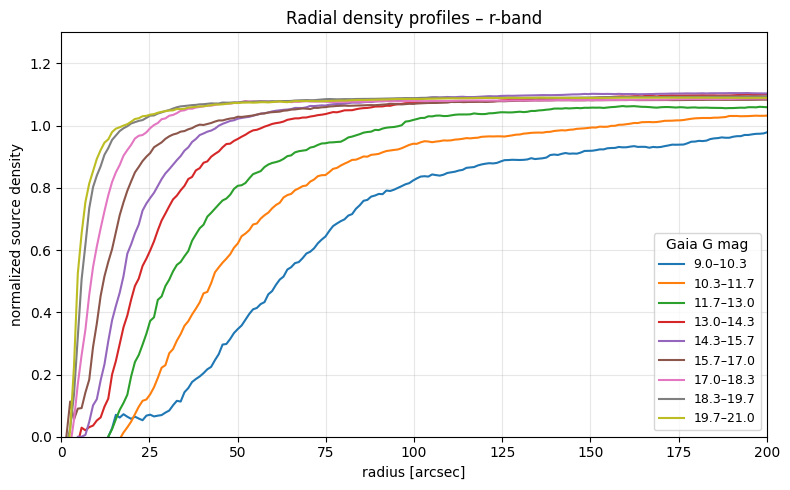

In [8]:
# Load density profiles and optionally plot them
profiles, mag_bins, r_arcsec = load_profiles_from_npy(profdir)
plotprofiles(profiles, mag_bins, band='r',xlim=[0,200])

In [9]:
# Create the profile interpolation model
#profile_model = make_profile_arcsec_model_from_profiles(
profile_model = build_radial_model(
    profiles=profiles,
    mag_bins=mag_bins,
    band=WM_band,
    p_floor_level=0.20,   # defines r_in and max weight ~ 1/0.2 = 5
    p_comp_level=0.85,    # defines r_out
    w_cap=None,           # or set e.g. 5.0 if you want a hard cap
    use_pchip=True,       # monotonic spline if scipy available
    dr_factor=1.0,        # ring step = ~1 pixel (no oversampling)
    weight_quant=1e-3,    # quantize weights (faster updates)
)

In [10]:
# Start dask client if needed
from dask.distributed import Client
client = Client(n_workers=3, threads_per_worker=1, memory_limit="6GiB")

In [11]:
# Create weight map
#wmap = mkp.build_star_weight_map_online_v2(
wmap = mkp.build_star_weightmask_online(
    starq=starq, order_sparse=WM_order_sparse, order_cov=WM_order_cov, profile_model=profile_model,
    output_stage_weight="starweight_mask", output_stage_core="starcore_mask")
client.close()

BUILDING STAR WEIGHTMASK >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
  order_sparse=15 nside_sparse=32768  pix~6.44"  dr_min~6.44"
  band=r  p_floor=0.2  p_comp=0.85  w_cap=None
  chunks=1
Chunk 1/1: querying catalog ...
--- Stars found : 53543


In [13]:
# Subtract the starcore to generate a non-core mask
mkp.combine(positive=['consmask'], negative=['starcore_mask'], order_out=15, order_cov=5, output_stage='cons_nc_mask');

[combine] aligning coverage for 'consmask' : c5 → c5
[combine] aligning coverage for 'starcore_mask' : c5 → c5
[combine] target=(o15, c5), work_order=12, r2=64
[combine:+] stage at order 12 -> work 12
[combine] done: order_out=15 (NSIDE=32768), order_cov=5 (NSIDE=32), valid_pix=26,996,952, area=86.435 deg², bit_packed=True


In [14]:
mkp

cons_nc_mask   : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=26996952  area= 86.43 deg² pix_size=   6.4"
consmask       : (ord/nside)cov=5/32   (ord/nside)sparse=12/4096  valid_pix=443232   area= 90.82 deg² pix_size=  51.5"
starcore_mask  : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=1624120  area=  5.20 deg² pix_size=   6.4"
starweight_mask: (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=2955314  area=  9.46 deg² pix_size=   6.4"

In [15]:
# Save to disk
mkp.write(WM_outdir, overwrite=True)

In [7]:
# Or read from disk
mkp = SkyMaskPipe.read(WM_outdir)

[read] Loading cons_nc_mask <- cons_nc_mask.fits (BITPACK)
[read] Loading consmask <- consmask.fits (BITPACK)
[read] Loading starcore_mask <- starcore_mask.fits (BITPACK)
[read] Loading starweight_mask <- starweight_mask.fits (OFFVAL)
[read] Done consmask (nside_cov=32, nside_sparse=4096, n_valid=443232)
[read] Done starweight_mask (nside_cov=32, nside_sparse=32768, n_valid=2955314)
[read] Done starcore_mask (nside_cov=32, nside_sparse=32768, n_valid=1624120)
[read] Done cons_nc_mask (nside_cov=32, nside_sparse=32768, n_valid=26996952)
[read] All stages attached.


Retrieving pixels inside clip box...
Found 104360 pixels
Creating display moc from pixels...
MOC max_order is 15 --> no degrading...
Drawing plot...
Retrieving pixels inside clip box...
Found 55694 pixels
Creating display moc from pixels...
MOC max_order is 15 --> no degrading...
Drawing plot...


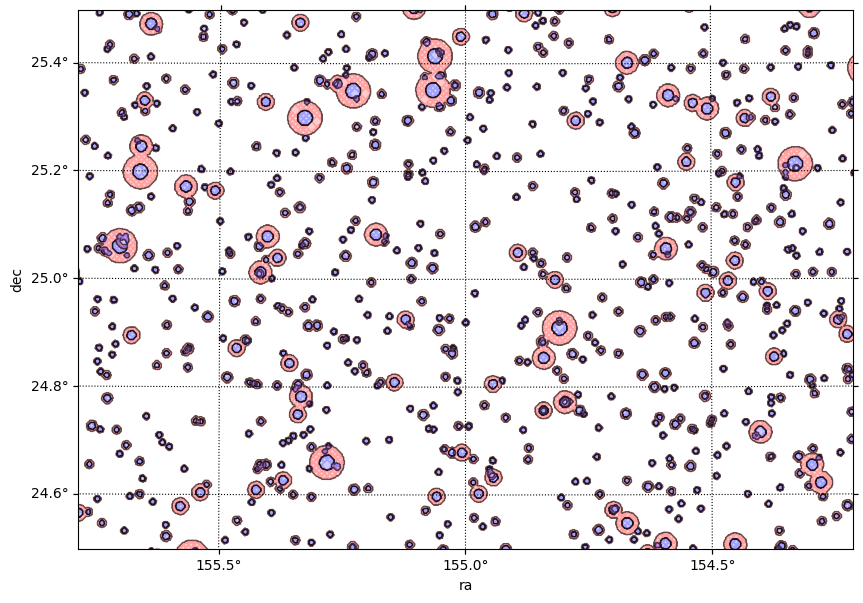

In [16]:
# Check plot
center = SkyCoord(155*u.deg, 25*u.deg)  ;  fov = 1*u.deg
clipra = [154,156]
clipdec = [24,26]
fig,ax,wcs = mkp.plot_moc(stage='starweight_mask', center=center, fov=fov, figsize=[10,7], color='r',
                          clipra=clipra, clipdec=clipdec);
mkp.plot_moc(stage='starcore_mask', center=center, fov=fov, ax=ax, wcs=wcs, color='b', alpha=0.2,
             clipra=clipra, clipdec=clipdec);

In [15]:
# Check min/max values
vals = mkp.starweight_mask.get_values_pix(mkp.starweight_mask.valid_pixels)
vmin = vals.min(); vmax = vals.max()
print(vmin,vmax)

1.194 3.621


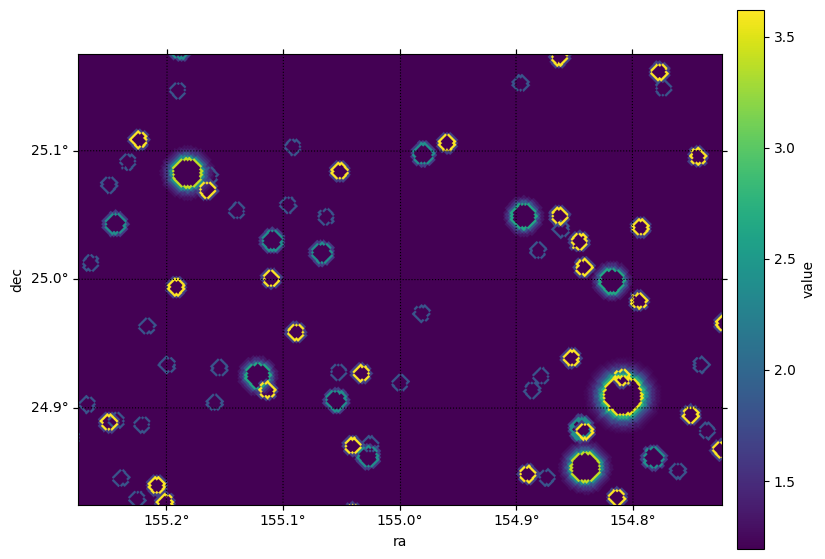

In [18]:
# Plot float map
center = SkyCoord(155*u.deg, 25*u.deg)  ;  fov = 0.35*u.deg
clipra = [30.,32.]
clipdec = [9., 11.]
fig, ax, wcs, im = mkp.plot_floatmap(stage='starweight_mask', center=center, fov=fov, figsize=[10,7], vmin=vmin, vmax=vmax);
#mkp.plot_moc(stage='starcore_mask', center=center, fov=fov, ax=ax, wcs=wcs, clipra=clipra, clipdec=clipdec, color='r', order_force=15);

In [20]:
# Now generate randoms over the non-core mask. There should be no need to generate different randoms
# for the subsamples split in uchuu mags, so do this only once
rancatfile = WM_outdir + '.rans.parquet'
mkp.makerans(stage='cons_nc_mask', nr=8_000_000, file=rancatfile);

8000000 randoms written to: ./euclid/small.rans.parquet


In [21]:
# Find out sources in the input mask, but outside the starcore
srcs = pd.read_parquet(lconefile) ; print(f'{len(srcs)} in {lconefile}')
srcs_in = mkp.apply(stage='cons_nc_mask', cat=srcs, columns=['ra_gal','dec_gal'])

4171559 in ./euclid/small.parquet
3970801 sources within cons_nc_mask


In [22]:
# Now weight sources in srcs_in, i.e. only apply weight outside starcore
#wcat = mkp.apply2(stage='starweight_mask', cat=srcs_in, columns=['ra_gal','dec_gal'], 
wcat = mkp.apply(stage='starweight_mask', cat=srcs_in, columns=['ra_gal','dec_gal'], 
                 include_background=True, default_weight=1.0)

3970801 sources returned (inside_with_weights=346671, outside=3624130, total=3970801)


In [24]:
# Export weighted catalog
wcatfile = lconefile.replace('.parquet', '_weighted.parquet')
wcat.to_parquet(wcatfile)

In [25]:
# In our mock (weighted) catalog, inject a deficit of sources around stars according to 1/weight_mask
keep, w_gal, c_gal = inject_star_deficit_from_weightmask(
                      wcat['ra_gal'].values, wcat['dec_gal'].values, mkp.starweight_mask, wcap=8)
wcat_thinned = wcat[keep]
print(f'input:{len(wcat)}  output: {len(wcat_thinned)}  thinned:{len(wcat)-len(wcat_thinned)}')

input:3970801  output: 3816019  thinned:154782


In [26]:
wthincatfile = wcatfile.replace('.parquet', '_thinned.parquet')
wcat_thinned.to_parquet(wthincatfile)

In [9]:
mkp

cons_nc_mask   : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=14872836  area= 47.62 deg² pix_size=   6.4"
consmask       : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=15769216  area= 50.49 deg² pix_size=   6.4"
starcore_mask  : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=1092686  area=  3.50 deg² pix_size=   6.4"
starweight_mask: (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=1971139  area=  6.31 deg² pix_size=   6.4"

In [4]:
mkp.change_sparse_order(stage='consmask', order=15)

[change_sparse_order] consmask requested upgrade o12 → o15
[change_sparse_order] consmask done: o15 (NSIDE=32768), cov=o5, n_valid=28,366,848, encoding=bit-packed


HealSparseMap: nside_coverage = 32, nside_sparse = 32768, boolean bit-packed mask, 28366848 valid pixels

In [9]:
rancatfile = WM_outdir + '.rans0.parquet'
mkp.makerans(stage='consmask', nr=8_000_000, file=rancatfile);  #1_650_000

8000000 randoms written to: ./euclid/small.rans0.parquet


In [10]:
rancatfile = WM_outdir + '.rans0.parquet'

Create a binary maxmask by thresholding the starweight and combining with starcore. Then cut raw mock data and make randoms --> calulate acf --> isolate the effect of weigthing vs simple hard cut 

In [8]:
mkp

cons_nc_mask   : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=26996952  area= 86.43 deg² pix_size=   6.4"
consmask       : (ord/nside)cov=5/32   (ord/nside)sparse=12/4096  valid_pix=443232   area= 90.82 deg² pix_size=  51.5"
starcore_mask  : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=1624120  area=  5.20 deg² pix_size=   6.4"
starweight_mask: (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=2955314  area=  9.46 deg² pix_size=   6.4"

Retrieving pixels inside clip box...
Found 25609 pixels
Creating display moc from pixels...
MOC max_order is 15 --> no degrading...
Drawing plot...


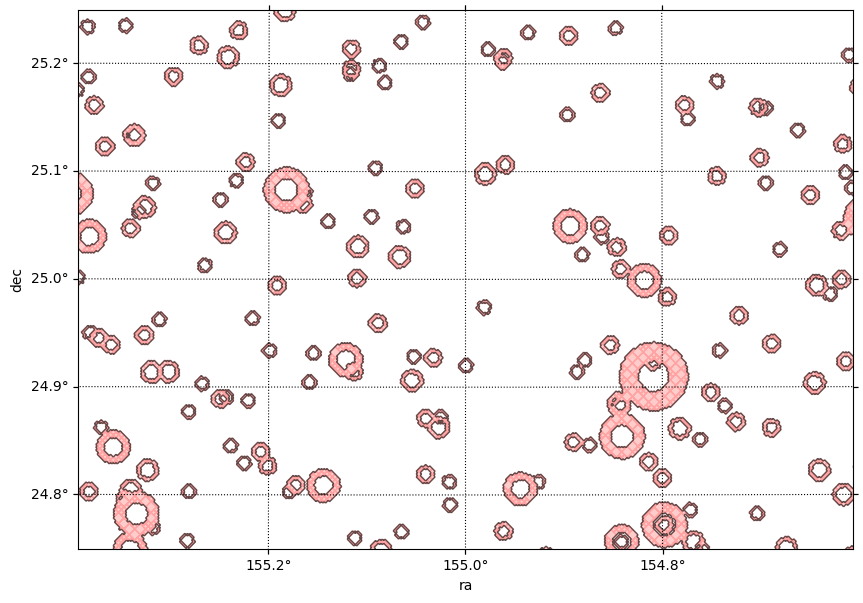

In [10]:
center = SkyCoord(155*u.deg, 25*u.deg)  ;  fov = 0.5*u.deg
clipra = [154.5,155.5]
clipdec = [24.5,25.5]
fig,ax,wcs = mkp.plot_moc(stage='starweight_mask', center=center, fov=fov, figsize=[10,7], color='r',
                          clipra=clipra, clipdec=clipdec);
#mkp.plot_moc(stage='starcore_mask', center=center, fov=fov, ax=ax, wcs=wcs, color='b', alpha=0.2,
#             clipra=clipra, clipdec=clipdec);

In [17]:
mkp.build_prop_mask(mkp.starweight_mask, thresholds=[1.0], comparisons=['gt'], output_stage='x0mask')

BUILDING PROPERTY MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Propertymap mask area                       : 9.461884535993935


HealSparseMap: nside_coverage = 32, nside_sparse = 32768, bool, 2955314 valid pixels

In [18]:
mkp

cons_nc_mask   : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=26996952  area= 86.43 deg² pix_size=   6.4"
consmask       : (ord/nside)cov=5/32   (ord/nside)sparse=12/4096  valid_pix=443232   area= 90.82 deg² pix_size=  51.5"
starcore_mask  : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=1624120  area=  5.20 deg² pix_size=   6.4"
starweight_mask: (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=2955314  area=  9.46 deg² pix_size=   6.4"
x0mask         : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=2955314  area=  9.46 deg² pix_size=   6.4"

In [24]:
mkp.combine(positive=[mkp.starcore_mask, mkp.x0mask], output_stage='maxmask')

[combine] aligning coverage for '<map>' : c5 → c5
[combine] aligning coverage for '<map>' : c5 → c5
[combine] target=(o15, c5), work_order=15, r2=1
[combine:+] stage at order 15 -> work 15
[combine:+] stage at order 15 -> work 15
[combine] done: order_out=15 (NSIDE=32768), order_cov=5 (NSIDE=32), valid_pix=4,420,518, area=14.153 deg², bit_packed=True


HealSparseMap: nside_coverage = 32, nside_sparse = 32768, boolean bit-packed mask, 4420518 valid pixels

In [25]:
mkp

cons_nc_mask   : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=26996952  area= 86.43 deg² pix_size=   6.4"
consmask       : (ord/nside)cov=5/32   (ord/nside)sparse=12/4096  valid_pix=443232   area= 90.82 deg² pix_size=  51.5"
maxmask        : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=4420518  area= 14.15 deg² pix_size=   6.4"
starcore_mask  : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=1624120  area=  5.20 deg² pix_size=   6.4"
starweight_mask: (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=2955314  area=  9.46 deg² pix_size=   6.4"
x0mask         : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=2955314  area=  9.46 deg² pix_size=   6.4"

Retrieving pixels inside clip box...
Found 37822 pixels
Creating display moc from pixels...
MOC max_order is 15 --> no degrading...
Drawing plot...


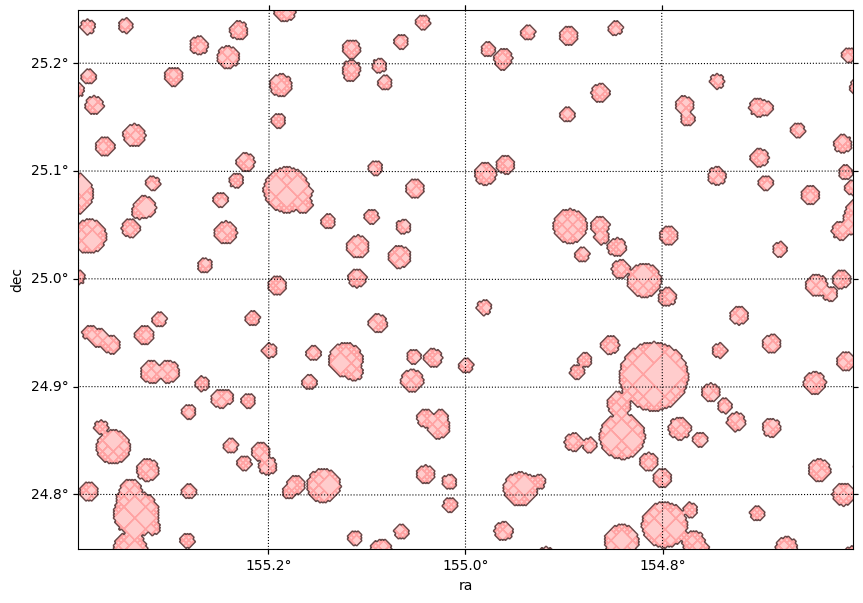

In [26]:
# Check plot
center = SkyCoord(155*u.deg, 25*u.deg)  ;  fov = 0.5*u.deg
clipra = [154.5,155.5]
clipdec = [24.5,25.5]
fig,ax,wcs = mkp.plot_moc(stage='maxmask', center=center, fov=fov, figsize=[10,7], color='r',
                          clipra=clipra, clipdec=clipdec);
#mkp.plot_moc(stage='starcore_mask', center=center, fov=fov, ax=ax, wcs=wcs, color='b', alpha=0.2,
#             clipra=clipra, clipdec=clipdec);

In [27]:
mkp.combine(positive=['consmask'], negative=['maxmask'], order_out=15, order_cov=5, output_stage='cons_nomax_mask');

[combine] aligning coverage for 'consmask' : c5 → c5
[combine] aligning coverage for 'maxmask' : c5 → c5
[combine] target=(o15, c5), work_order=12, r2=64
[combine:+] stage at order 12 -> work 12
[combine] done: order_out=15 (NSIDE=32768), order_cov=5 (NSIDE=32), valid_pix=24,640,953, area=78.892 deg², bit_packed=True


In [28]:
mkp

cons_nc_mask   : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=26996952  area= 86.43 deg² pix_size=   6.4"
cons_nomax_mask: (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=24640953  area= 78.89 deg² pix_size=   6.4"
consmask       : (ord/nside)cov=5/32   (ord/nside)sparse=12/4096  valid_pix=443232   area= 90.82 deg² pix_size=  51.5"
maxmask        : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=4420518  area= 14.15 deg² pix_size=   6.4"
starcore_mask  : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=1624120  area=  5.20 deg² pix_size=   6.4"
starweight_mask: (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=2955314  area=  9.46 deg² pix_size=   6.4"
x0mask         : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=2955314  area=  9.46 deg² pix_size=   6.4"

In [29]:
srcs = pd.read_parquet(lconefile) ; print(f'{len(srcs)} in {lconefile}')

4171559 in ./euclid/small.parquet


In [30]:
srcs_in = mkp.apply(stage='cons_nomax_mask', cat=srcs, columns=['ra_gal','dec_gal'])

3624130 sources within cons_nomax_mask


In [34]:
cutted_catfile = lconefile.replace('.parquet', '_nomax.parquet')
print(cutted_catfile)
srcs_in.to_parquet(cutted_catfile)

./euclid/small_nomax.parquet


In [37]:
rancatfile = WM_outdir + '.rans.nomax.parquet'
print(rancatfile)
mkp.makerans(stage='cons_nomax_mask', nr=8_000_000, file=rancatfile);

./euclid/small.rans.nomax.parquet
8000000 randoms written to: ./euclid/small.rans.nomax.parquet


In [40]:
# Now save the mask with the new cons_nomax_mask stage (the usual boolean mask at p=0.85)
mkp.write(WM_outdir, overwrite=True)

/home/edonoso/proj/skykatana/src/skykatana/skykatana.py:513: DeprecationWarning: The keyword arguments '{'formats': ['K', 'B', 'J', 'PJ()', 'PE()']}' are being ignored! This warning will be an error in a future version of `fitsio`!
  fits.write(


In [41]:
mkp

cons_nc_mask   : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=26996952  area= 86.43 deg² pix_size=   6.4"
cons_nomax_mask: (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=24640953  area= 78.89 deg² pix_size=   6.4"
consmask       : (ord/nside)cov=5/32   (ord/nside)sparse=12/4096  valid_pix=443232   area= 90.82 deg² pix_size=  51.5"
maxmask        : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=4420518  area= 14.15 deg² pix_size=   6.4"
starcore_mask  : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=1624120  area=  5.20 deg² pix_size=   6.4"
starweight_mask: (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=2955314  area=  9.46 deg² pix_size=   6.4"
x0mask         : (ord/nside)cov=5/32   (ord/nside)sparse=15/32768 valid_pix=2955314  area=  9.46 deg² pix_size=   6.4"

In [57]:
# Now do some statistics of area gained #####################
# Area recovered by using the weighted mask instead of a bool mask hard cut at p=0.85
arec_weight_deg = mkp.cons_nc_mask.get_valid_area() - mkp.cons_nomax_mask.get_valid_area()
arec_weight_frac = arec_weight_deg / mkp.consmask.get_valid_area()
print(f'area gained by using weight mask: {arec_weight_deg:.2f} deg ({100*arec_weight_frac:.2f}%)')

area gained by using weight mask: 7.54 deg (8.31%)
